# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [1]:
import pandas as pd
import numpy as np
import math

## Загрузка и предобработка данных

Загрузим данные и проведем предобраотку данных как на семинаре.

In [2]:
!wget -q -N https://www.dropbox.com/s/z8syrl5trawxs0n/articles.zip?dl=0 -O articles.zip
!unzip -o -q articles.zip

In [3]:
articles_df = pd.read_csv('articles/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [4]:
interactions_df = pd.read_csv('articles/users_interactions.csv')
interactions_df.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [5]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [6]:
# зададим словарь определяющий силу взаимодействия
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.

In [7]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [8]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [9]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье и сглажиываем полученный результат, взяв от него логарифм.

In [10]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [11]:
from sklearn.model_selection import train_test_split

#interactions_full_df = interactions_full_df.sort_values(by=['contentId'])
split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

#interactions_train_df = interactions_train_df.sort_values(by=['contentId'])
#interactions_test_df = interactions_test_df.sort_values(by=['contentId'])

# interactions on Train set: 29329
# interactions on Test set: 9777


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [12]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


## Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [13]:
!pip install lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

     |████████████████████████████████| 317kB 4.0MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705336 sha256=65ad207e81dc26543b05769bf42d69954c12cbe86b35573c43ac4b9bca5963ee
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


## Задание 1. (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

In [14]:
# Ваш код здесь
from scipy.sparse import csr_matrix

def transform(df):
    users = interactions_full_df['personId'].unique()
    articles = interactions_full_df['contentId'].unique()
    matrix = np.zeros((len(users), len(articles)))
    new_df = pd.DataFrame(matrix, columns=articles, index=users)
    for user in users:
        contents = df[df['personId'] == user].to_numpy()
        for content in contents:
            new_df.loc[user][content[1]] = content[2]
    new_matrix = new_df.to_numpy()
    return csr_matrix(new_matrix)

data_train = transform(interactions_train_df)
data_test = transform(interactions_test_df)

## Задание 2. (1 балл)

Обучите модель LightFM с `loss='warp'` и посчитайте *precision@10* на тесте.

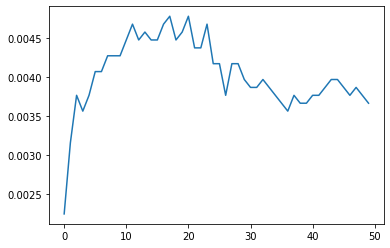

In [15]:
# Ваш код здесь
import matplotlib.pyplot as plt

model = LightFM(loss='warp', random_state=42)
epochs = 50

warp_auc = []

for epoch in range(epochs):
    model.fit_partial(data_train, epochs=1)
    warp_auc.append(precision_at_k(model, data_test).mean())

plt.plot(warp_auc)
plt.show()

## Задание 3. (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количесвто статей на размер признакового описание и обучите LightFM с `loss='warp'` и посчитайте precision@10 на тесте.

In [16]:
# Ваш код здесь
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100)

articles_unique = interactions_full_df['contentId'].unique()
articles_text = pd.DataFrame(columns=['contentId', 'text'])
for content in articles_unique:
    try:
        new_row = {'contentId': content, 'text': articles_df[articles_df['contentId'] == content]['text'].values[0]}
    except IndexError:
        new_row = {'contentId': content, 'text': ' '}

    articles_text = articles_text.append(new_row, ignore_index=True)

corpus = articles_text['text'].values
feat = vectorizer.fit_transform(corpus)

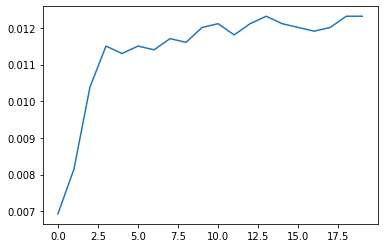

In [17]:
model = LightFM(loss='warp', random_state=42)

warp_auc = []
epochs = 20

for epoch in range(epochs):
    model.fit_partial(data_train, epochs=1, item_features=feat)
    warp_auc.append(precision_at_k(model, data_test, item_features=feat).mean())

plt.plot(warp_auc)
plt.show()

## Задание 4. (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к номральной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

In [ ]:
import nltk
nltk.download('all')

In [19]:
# Ваш код здесь
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) | set(stopwords.words('spanish')) | set(stopwords.words('portuguese'))
lemmatizer = WordNetLemmatizer()
vectorizer = TfidfVectorizer(max_features=100)
corpus = articles_text['text'].values

def text_transform(texts):
    output_corpus = []
    for text in texts:
        text = word_tokenize(text.lower())
        text = [lemmatizer.lemmatize(word, pos ='v') for word in text]
        text = [word for word in text if word not in stop_words]
        text = ' '.join(text)
        output_corpus.append(text)
    return output_corpus
    
corpus = text_transform(corpus)
feat = vectorizer.fit_transform(corpus)

Test: 0.009266803
Train: 0.06942446


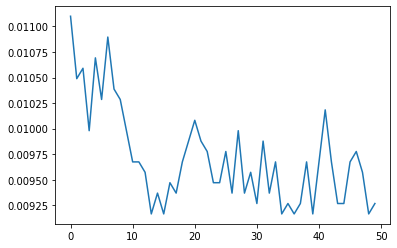

In [20]:
model = LightFM(loss='warp', random_state=42)

warp_auc = []
epochs = 50

for epoch in range(epochs):
    model.fit_partial(data_train, epochs=1, item_features=feat)
    warp_auc.append(precision_at_k(model, data_test, item_features=feat).mean())

print('Test:', precision_at_k(model, data_test, item_features=feat).mean())
print('Train:', precision_at_k(model, data_train, item_features=feat).mean())
plt.plot(warp_auc)
plt.show()

Улучшилось ли качество предсказания?

## Задание 5. (2 балла)

Подберите гиперпараметры модели LightFM (`n_components` и др.) для улучшения качества модели.

In [29]:
# Ваш код здесь
alpha = 4e-5
epochs = 1
num_components = 10
lr = 0.001
rho = 5e-5
epsilon = 1e-7

model = LightFM(no_components=num_components, loss='warp', learning_schedule='adadelta', learning_rate=lr,
                max_sampled=10, user_alpha=alpha, item_alpha=alpha, rho=rho, epsilon=epsilon, random_state=42)

warp_auc = []

for epoch in range(epochs):
    model.fit_partial(data_train, epochs=20, item_features=feat)
    warp_auc.append(precision_at_k(model, data_test, item_features=feat).mean())

print('Test:', precision_at_k(model, data_test, item_features=feat).mean())
print('Train:', precision_at_k(model, data_train, item_features=feat).mean())
#plt.plot(warp_auc)
#plt.show()

Test: 0.022505093
Train: 0.023111511


## Бонусное задание. (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмеддингов и сравните результаты с предыдущими.

In [ ]:
# Ваш код здесь